In [1]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import numpy.ma as ma

import calendar
import time
from scipy.stats import gmean

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [2]:

# run installed version of flopy or add local path
try:
    import flopy
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference
    from flopy.utils import Raster
except:
    import flopy
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference
    from flopy.utils import Raster
from flopy.utils.gridgen import Gridgen
from flopy.utils import OptionBlock
import flopy.utils.binaryfile as bf


print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.7.10 (default, Feb 26 2021, 13:06:18) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.19.2
matplotlib version: 3.3.4
flopy version: 3.3.4


In [3]:
## Set up directory referencing
# Package data
gwfm_dir = os.path.dirname(os.path.dirname(os.getcwd()))
gwfm_dir

'C:\\Users\\ajcalder\\Box\\research_cosumnes\\GWFlowModel'

In [4]:
# loadpth = 'C:/WRDAPP/GWFlowModel/Cosumnes_Blodgett_10yr/'
loadpth = 'F:/WRDAPP/GWFlowModel/Cosumnes/Cosumnes_Blodgett_10yr/'

model_ws = loadpth+'WEL_SFR_RCH_layercake'

In [20]:
gel_dir = gwfm_dir+'/UPW_data'
if 'ZonePropertiesInitial.csv' in os.listdir(model_ws):
    params = pd.read_csv(model_ws+'/ZonePropertiesInitial.csv',index_col='Zone')
else:
    params = pd.read_csv(gel_dir+'/ZonePropertiesInitial.csv',index_col='Zone')
    params.to_csv(model_ws+'/ZonePropertiesInitial.csv')
# convert from m/s to m/d
params['K_m_d'] = params.K_m_s * 86400    

In [6]:
def tprogs_cut_elev(tprogs_line, dem_data, **kwargs):
    rows = kwargs.get('rows', np.where(np.ones(dem_data.shape)==1)[0])
    cols = kwargs.get('cols', np.where(np.ones(dem_data.shape)==1)[1])
    tprogs_arr = np.reshape(tprogs_line, (320, 100,230))
    tprogs_c = np.reshape(tprogs_arr[:, rows,cols],
                             (tprogs_arr.shape[0],dem_data.shape[0],dem_data.shape[1]))
    tprogs_elev = np.copy(tprogs_c)
    # the bottom layer of the tprogs model is at -50 m amsl and the top layer is 50 m amsl
    t = 0
    for k in np.arange(-80,80,0.5):
        tprogs_elev[t,dem_data<k]= np.NaN
        t+=1
    masked_tprogs = ma.masked_invalid(tprogs_elev)
    return(masked_tprogs)

In [7]:
def int_to_param(tprogs):
    tprogs[tprogs<0] *= -1
    tprogs = tprogs.astype(float)
    # flip tprogs model along z axis to match modflow definition of 0 as top (TPROGS says 0 is bottom)
    tprogs = np.flip(tprogs,axis=0)
    tprogs_K = np.copy(tprogs)
    tprogs_Sy = np.copy(tprogs)
    tprogs_Ss = np.copy(tprogs)
    # hydraulic parameters from fleckenstein 2006
    # I-IV gravel, sand, muddy sand, mud
    # K in m/s, Sy, Ss
    for n in np.arange(1,5):
        tprogs_K[tprogs==n]= params.loc[n,'K_m_d']
    for n in np.arange(1,5):
        tprogs_Sy[tprogs==n]= params.loc[n,'Sy']
    for n in np.arange(1,5):
        tprogs_Ss[tprogs==n]= params.loc[n,'Ss']
            
    return(tprogs_K,tprogs_Sy,tprogs_Ss)


In [8]:
mf_tprogs_dir = gwfm_dir+'/UPW_data/tprogs_final/'
tprogs_files = glob.glob(mf_tprogs_dir+'*')



In [28]:
child_connections = gpd.read_file(gwfm_dir+'/Blodgett_Dam/geospatial/child_connections/child_connections.shp')
grid_c_py = pd.read_csv(gwfm_dir+'/Blodgett_Dam/geospatial/child_connections/child_connections_0based.csv')

topbotm = np.loadtxt(gwfm_dir+'/Blodgett_Dam/geospatial/DIS_data/topbotm_child.tsv')
topbotm = np.reshape(topbotm, (int(topbotm.shape[0]/topbotm.shape[1]),topbotm.shape[1], topbotm.shape[1]))

# SFR analysis

In [33]:
grid_sfr = gpd.read_file(gwfm_dir+'/Blodgett_Dam/geospatial/child_grid_sfr/child_grid_sfr.shp')
sfr_rows = (grid_sfr.row.values-1).astype(int)
sfr_cols = (grid_sfr.column.values-1).astype(int)


In [9]:
def elev_to_tprogs_layers(elev):
    # function to get the tprogs layers based on the given elevation
    # layer 0 is 80 meters, layer 1 is 79.5 meters, layer -1 is -80 meters
    elev_05 = np.round((elev) * 2) / 2 # dem rounded to the nearest 0.5
    elev_05[elev_05 >= 80] = 80# any elevation above 80 m is set to 80
    elev_indices = 160 - elev_05*2 # subtract the calculated row from 160 to get to 0 at 160 and 320 and -160
    return(elev_indices.astype(int))
    
def get_tprogs_for_elev(tprogs_arr, top_elev, bot_elev, **kwargs):
    rows = kwargs.get('rows', np.where(np.ones(top_elev.shape)==1)[0])
    cols = kwargs.get('cols', np.where(np.ones(top_elev.shape)==1)[1])
    top_indices = elev_to_tprogs_layers(top_elev)
    bot_indices = elev_to_tprogs_layers(bot_elev)
    # find tprogs layer for desired rows and columns
    top_indices = top_indices[rows, cols].astype(int)
    bot_indices = bot_indices[rows, cols].astype(int)
    # the first row of the array will be the top layer and will progress downward until the max bottom is reached
    # with NaNs for rows,cols where there are less layers indexed than the max
    tprogs_subset = np.full(shape = (np.max(bot_indices - top_indices).astype(int), len(rows)),
                       fill_value = np.nan, dtype = float)
    max_layers = np.max(bot_indices - top_indices)
    for k in np.arange(0,max_layers):
        layexist = (bot_indices-top_indices) > k # pick where data should be referenced
        tprogs_subset[k, layexist] = K[top_indices[layexist]+k, rows[layexist], cols[layexist]]
    # return grabbed data in array format if entire domain was used
    if len(rows) == top_elev.shape[0]*top_elev.shape[1]:
        tprogs_subset = np.reshape(tprogs_subset, (max_layers, top_elev.shape[0], top_elev.shape[1]))
    return(tprogs_subset)

In [34]:

sfr_tprogs_K_all = np.zeros((len(tprogs_files),len(sfr_rows)))

In [55]:
for t in np.arange(0,100):
    tprogs_line = np.loadtxt(tprogs_files[t])
    masked_tprogs=tprogs_cut_elev_child(tprogs_line, topbotm[0,:,:], child_connections)
    K, Sy, Ss= int_to_param(masked_tprogs)

    strbd_thick = 4
    strbd_tprogs = get_tprogs_for_elev(K, topbotm[0,:,:], topbotm[0,:,:] - strbd_thick, rows = sfr_rows, cols = sfr_cols)
    sfr_tprogs_K_all[t,:] = gmean(strbd_tprogs, axis=0)

In [59]:
# np.savetxt(gwfm_dir+'/Blodgett_Dam/geospatial/sfr_tprogs_K_all_4m_thick.tsv',sfr_tprogs_K_all)

In [66]:
grid_sfr['dist_m'] = grid_sfr.length_m.cumsum()

All of the values are the same for this reach of the Cosumnes River

In [119]:
print(np.histogram(sfr_tprogs_K_all_4m_thick, bins=[0.5,1,50, 350]))

# sfr_tprogs_K_all_4m_thick

(array([4548, 2083,  469], dtype=int64), array([  0.5,   1. ,  50. , 350. ]))


In [277]:
c_sfr_K = np.loadtxt(gwfm_dir+'/Blodgett_Dam/geospatial/sfr_tprogs_K_all_4m_thick.tsv')


The overall shape of the vertical hydraulic conductivity down the river channel for the child grid is near the same for all, except for the magnitude of the high hydraulic conductivity zones.

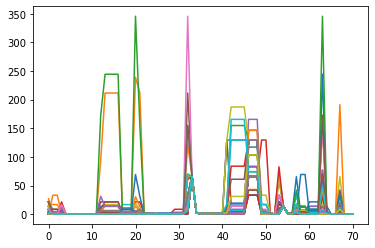

In [278]:
c_sfr_K.shape
for n in np.arange(0,c_sfr_K.shape[0]):
    plt.plot(c_sfr_K[n,:])

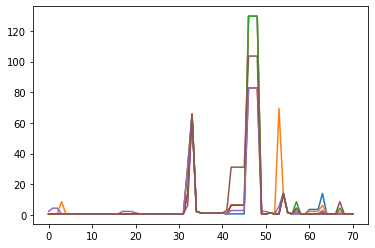

In [127]:
# Initialise KMeans instance
from sklearn.cluster import KMeans
from sklearn.preprocessing import robust_scale




## Correlation coefficient between realizations clipped to the streambed
The Pearson product-moment correlation coefficient was useful in determining non-correlated streambed hydraulic conductivity realizations. 

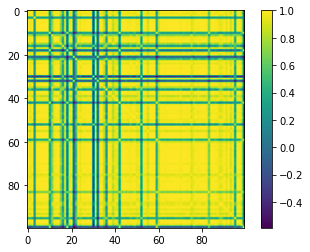

Number of realizations:  10 . Realizations are:  [ 3 10 18 21 30 32 42 52 59 99]


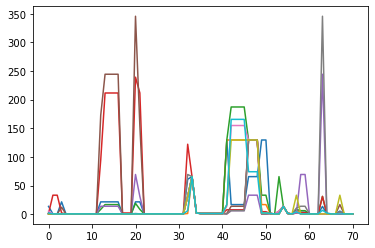

In [287]:
corr_cutoff = 0.745
tprogs_corrcoef = np.corrcoef(c_sfr_K)
plt.imshow(np.corrcoef(tprogs_corrcoef))
plt.colorbar()
plt.show()

corrcoef_log = (tprogs_corrcoef<corr_cutoff)
# filter out for realizations that had more than 90% of the correlation coefficients less than the cutoff
c_realizations = np.where(corrcoef_log.sum(axis=0)>len(corrcoef_log)*0.9)[0]
print('Number of realizations: ', len(c_realizations),'. Realizations are: ', c_realizations)
for n in c_realizations:
    plt.plot(c_sfr_K[n,:])

In [164]:
def tprogs_K_qaunts(tprogs_K_stat, sfr_tprogs_K_all_4m_thick):
    quants = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
    tprogs_K_quants = np.quantile(tprogs_K_stat, q = quants, interpolation = 'nearest')
    realizations = np.zeros(len(quants), dtype=int)
    # if more than one realization meets the quantile then pick the first one
    for t in np.arange(0,len(quants)):
        realizations[t] = np.where(tprogs_K_stat == tprogs_K_quants[t])[0][0]

    for n in realizations:
        plt.plot(sfr_tprogs_K_all_4m_thick[n,:])

1.  The overall geometric mean for all 100 realizations is not too different, there is a range of 1-3 m/day.   
2. The max VKA showed significant variability with a tendency of a maximum value toward 50, 125 and a few highs around 300.   
3. The max VKA location down the channel tended to be around reach 45 but ranged from 20-60.

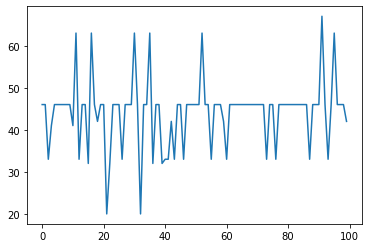

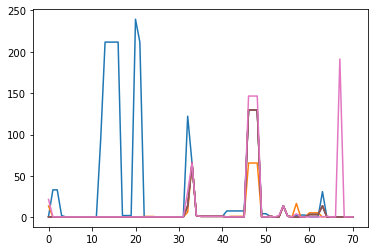

In [213]:
# tprogs_stat = gmean(c_sfr_K,axis=1)
# tprogs_stat = np.max(c_sfr_K,axis=1)
tprogs_stat = np.argmax(c_sfr_K,axis=1)

plt.plot(tprogs_stat)
plt.show()
tprogs_K_qaunts(tprogs_stat, sfr_tprogs_K_all_4m_thick)

# Parent model analysis


In [10]:
m_p = flopy.modflow.Modflow.load('MF.nam',model_ws = model_ws)

ValueError: no field of name lgrgrid

In [229]:
p_top = m_p.dis.top.array

In [238]:
tprogs_line = np.loadtxt(tprogs_files[t])
masked_tprogs=tprogs_cut_elev(tprogs_line, p_top)
K, Sy, Ss= int_to_param(masked_tprogs)

In [240]:
# grid_sfr.to_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')
grid_sfr = gpd.read_file(gwfm_dir+'/SFR_data/final_grid_sfr/grid_sfr.shp')
sfr_rows = (grid_sfr.row.values-1).astype(int)
sfr_cols = (grid_sfr.column.values-1).astype(int)


In [241]:
sfr_tprogs_K_all = np.zeros((len(tprogs_files),len(sfr_rows)))

In [250]:
# the tprogs cropping  took 1/2 hour
t0 = time.time()

strbd_thick = 4
for t in np.arange(0,100):
    tprogs_line = np.loadtxt(tprogs_files[t])
    masked_tprogs=tprogs_cut_elev(tprogs_line, p_top)
    K, Sy, Ss= int_to_param(masked_tprogs)

    strbd_tprogs = get_tprogs_for_elev(K, p_top, p_top - strbd_thick, rows = sfr_rows, cols = sfr_cols)
    sfr_tprogs_K_all[t,:] = gmean(strbd_tprogs, axis=0)
crop_time = time.time() - t0
print('Tprogs crop time:', crop_time/60, 'minutes, ', crop_time/3600, 'hours')

In [251]:
# np.savetxt(gwfm_dir+'/SFR_data/sfr_tprogs_K_all_4m_thick.tsv',sfr_tprogs_K_all)

In [11]:
p_sfr_K = np.loadtxt(gwfm_dir+'/SFR_data/sfr_tprogs_K_all_4m_thick.tsv')


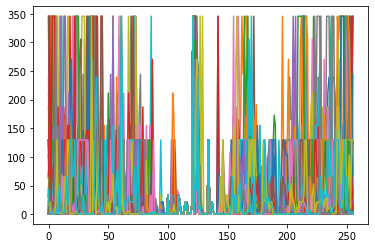

In [12]:
p_sfr_K.shape
for n in np.arange(0,p_sfr_K.shape[0]):
    plt.plot(p_sfr_K[n,:])

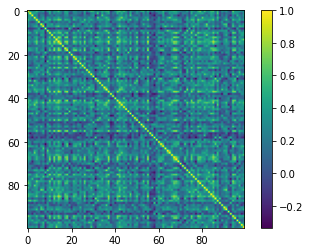

Number of realizations:  10 . Realizations are:  [20 27 38 40 51 52 56 57 71 93]


In [20]:
corr_cutoff = 0.397
tprogs_corrcoef = np.corrcoef(p_sfr_K)
plt.imshow(np.corrcoef(tprogs_corrcoef))
plt.colorbar()
plt.show()

corrcoef_log = (tprogs_corrcoef<corr_cutoff)
# filter out for realizations that had more than 90% of the correlation coefficients less than the cutoff
p_realizations = np.where(corrcoef_log.sum(axis=0)>len(corrcoef_log)*0.9)[0]
print('Number of realizations: ', len(p_realizations),'. Realizations are: ', p_realizations)


Text(0.5, 0, 'Reach number')

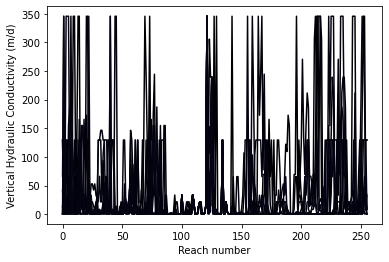

In [30]:
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('magma').colors)
for n in p_realizations:
    plt.plot(p_sfr_K[n,:])

plt.ylabel('Vertical Hydraulic Conductivity (m/d)')
plt.xlabel('Reach number')

1.  The overall geometric mean for all 100 realizations is not too different, there is a range of 1.5-5 m/day.   
2. The max VKA showed zero variability which makes sense as you increase the area there must be one location with only gravel which will lead to the VKA of gravel.   
3. Because the max VKA is the same for all and each has multiple it appears that the location of the maximum will be earlier although there are more equal maximums later

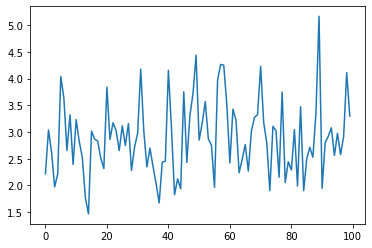

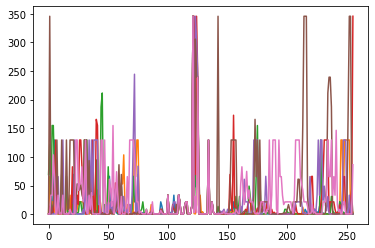

In [266]:
tprogs_stat = gmean(sfr_tprogs_K_all_4m_thick,axis=1)
# tprogs_stat = np.max(sfr_tprogs_K_all_4m_thick,axis=1)
# tprogs_stat = np.argmax(sfr_tprogs_K_all_4m_thick,axis=1)

plt.plot(tprogs_stat)
plt.show()
tprogs_K_qaunts(tprogs_stat, sfr_tprogs_K_all_4m_thick)